In [1]:
cd ..

/home/peter/projects/dog_breed_classification


In [169]:
from torchvision import models, transforms, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torchvision.transforms.functional as TF
import torch
import os
import utils
import matplotlib.pyplot as plt
from torchcontrib.optim import SWA
from PIL import Image
import pandas as pd
from torch.nn import Softmax

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
class RandomNoise(object):
    '''
    Must be applied after image normalization
    '''
    
    def __init__(self, noise_level=.1):
        self.noise_level = noise_level

    def __call__(self, img):
        if not TF._is_pil_image(img):
            raise TypeError('Not PIL Image')

        img_tensor = TF.to_tensor(img)
        img_noisy = img_tensor + self.noise_level * torch.randn(*img_tensor.shape)
        img_noisy = torch.clamp(img_noisy, 0, 1)
            
        return TF.to_pil_image(img_noisy)


def set_model_untrainable(model):
    
    for param in model.parameters():
        param.requires_grad = False
    
    return model


def set_layer_trainable(model, trainable_layers):

    for name, param in model.named_parameters():
        for layer in trainable_layers:
            if layer in name:
                param.requires_grad = True
    
    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy(predicted_scores, y):
    predicted_classes = predicted_scores.argmax(dim=1, keepdim=True)
    correct = (predicted_classes == y.view_as(predicted_classes)).sum()
    return correct.float() / y.shape[0]

def train(model, iterator, optimizer, criterion, scheduler=None):
    epoch_loss, epoch_acc = 0, 0
    
    model.train()
    for x, y in iterator:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        acc = accuracy(predictions, y)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss, epoch_acc = 0, 0
    
    model.eval()
    for x, y in iterator:
        x, y = x.to(device), y.to(device)
        
        predictions = model(x)
        loss = criterion(predictions, y)
        acc = accuracy(predictions, y)
        loss.backward()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def val_improvement(model, val_loss, best_val_loss, no_improvement_cnt):
    
    if val_loss < best_val_loss:
        print(f'***********Loss improved from {best_val_loss:.3f} to {val_loss:.3f}***********')
        no_improvement_cnt = 0
        best_val_loss = val_loss
#         torch.save(model.state_dict(), MODEL_PATH + MODEL_NAME)
    else:
        no_improvement_cnt += 1
        
    return val_loss, best_val_loss, no_improvement_cnt

In [4]:
MAIN_DIR = '/data/dog_breeds/'
train_dir = os.path.join(MAIN_DIR, 'train')
val_dir = os.path.join(MAIN_DIR, 'val')
test_dir = os.path.join(MAIN_DIR, 'test')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
generic_transforms = [transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])]

train_specific_transforms = [transforms.RandomHorizontalFlip(),
                             transforms.RandomRotation(10),
                             transforms.RandomCrop((224, 224), pad_if_needed=True),
                             RandomNoise(.015)
                            ]

test_specific_transforms = [transforms.CenterCrop((224, 224))]

train_transforms = transforms.Compose(train_specific_transforms + generic_transforms)
test_transforms = transforms.Compose(test_specific_transforms + generic_transforms)

In [6]:
train_data = ImageFolder(train_dir, train_transforms)
val_data = ImageFolder(val_dir, test_transforms)

In [7]:
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_iterator = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

In [14]:
model = models.resnet152(pretrained=True).to(device)

model = set_model_untrainable(model)

model.fc = nn.Linear(2048, len(train_data.classes)).to(device)

MODEL_PATH = 'models/'
MODEL_NAME = 'resnet152{}.pt'

In [15]:
print(f'The model has {count_parameters(model):,} trainable parameters')

base_lr = 5e-2
base_opt = torch.optim.SGD(model.parameters(), momentum=.9, lr=base_lr)
optimizer = SWA(base_opt, swa_start=10, swa_freq=3, swa_lr=base_lr * .5)

criterion = nn.CrossEntropyLoss()

The model has 245,880 trainable parameters


In [16]:
trainable_layers = ['layer4']

In [17]:
EPOCHS = 100
PATIENCE = 5
best_val_loss = float('inf')

utils.make_folder(MODEL_PATH)

train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

no_improvement_cnt = 0
trainable = False
for epoch in range(EPOCHS):
        
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_iterator, criterion)
        
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc) 
    
    
    if train_loss < val_loss:
        if not trainable:
            print('train_loss < val_loss')

            model = set_layer_trainable(model, trainable_layers).to(device)
            no_improvement_cnt = 0
            best_val_loss = float('inf')
            trainable = True
            
            new_base_lr = base_lr * .7
            base_opt = torch.optim.SGD(model.parameters(), lr=new_base_lr)
            optimizer = SWA(base_opt, swa_start=10, swa_freq=3, swa_lr=new_base_lr * .6)
            torch.save(model.state_dict(), MODEL_PATH + MODEL_NAME.format('_unfreeze_checkpt'))
            
        if no_improvement_cnt >= PATIENCE:
            print(f'No improvements after {PATIENCE} epochs.')
            break
            
    val_loss, best_val_loss, no_improvement_cnt = val_improvement(model, val_loss, best_val_loss, no_improvement_cnt)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:05.2f}% |')    

torch.save(model.state_dict(), MODEL_PATH + MODEL_NAME.format('_final'))

***********Loss improved from inf to 0.982***********
| Epoch: 01 | Train Loss: 2.485 | Train Acc: 47.65% | Val. Loss: 0.982 | Val. Acc: 76.90% |
***********Loss improved from 0.982 to 0.752***********
| Epoch: 02 | Train Loss: 1.089 | Train Acc: 72.39% | Val. Loss: 0.752 | Val. Acc: 78.94% |
***********Loss improved from 0.752 to 0.740***********
| Epoch: 03 | Train Loss: 0.928 | Train Acc: 75.71% | Val. Loss: 0.740 | Val. Acc: 79.00% |
***********Loss improved from 0.740 to 0.680***********
| Epoch: 04 | Train Loss: 0.845 | Train Acc: 77.54% | Val. Loss: 0.680 | Val. Acc: 79.90% |
***********Loss improved from 0.680 to 0.633***********
| Epoch: 05 | Train Loss: 0.794 | Train Acc: 78.76% | Val. Loss: 0.633 | Val. Acc: 81.34% |
| Epoch: 06 | Train Loss: 0.762 | Train Acc: 78.54% | Val. Loss: 0.639 | Val. Acc: 80.68% |
***********Loss improved from 0.633 to 0.612***********
| Epoch: 07 | Train Loss: 0.753 | Train Acc: 79.07% | Val. Loss: 0.612 | Val. Acc: 81.78% |
| Epoch: 08 | Train Lo

In [18]:
optimizer.swap_swa_sgd()
optimizer.bn_update(train_iterator, model.cuda(), device=device)

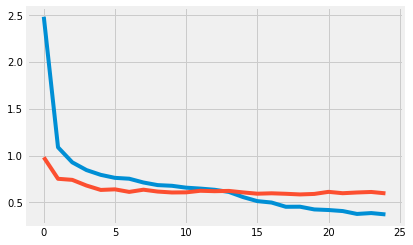

In [19]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)

# Prediction

In [20]:
model.load_state_dict(torch.load(MODEL_PATH + MODEL_NAME.format('_final')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [21]:
class_map = {idx: cls for cls, idx in train_data.class_to_idx.items()}

In [22]:
def predict(model, filepaths, transforms):
    model.eval()
    
    batch_size = len(filepaths)
    imgs = torch.zeros(batch_size, 3, 224, 224).to(device)
    
    for i, file in enumerate(filepaths):
        img = Image.open(file)
        img = transforms(img)
        imgs[i] = img
    
    scores = torch.softmax(model(imgs), dim=1)
    idx_predicts = torch.argmax(scores, dim=1)
    class_predicts = [class_map[idx.item()] for idx in idx_predicts]
    class_scores = [scores[i][idx].item() for i, (score, idx) in enumerate(zip(scores, idx_predicts))]
    
    for filepath, predict in zip(filepaths, class_predicts):
        plt.imshow(Image.open(filepath))
        plt.axis('off')
        plt.show()
        print(predict)
        
    return class_predicts, class_scores

In [151]:
class TestDataset(Dataset):
    
    def __init__(self, test_dir, transform=None):
        files = os.listdir(test_dir)
        self.files = list(map(lambda file: os.path.join(test_dir, file), files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img = Image.open(file)
        
        if self.transform is not None:
            img = self.transform(img)
        
        file = file.split('/')[-1][:-4]
        return file, img

In [203]:
def kaggle_predict(model, test_dir):
    tds = TestDataset(test_dir, transform=test_transforms)
    test_iterator = DataLoader(tds, batch_size=BATCH_SIZE)
    
    model.eval()
    model = model.to(device)
    results_df = pd.DataFrame(columns=class_map.values())
    with torch.no_grad():
        for fn, batch in test_iterator:
            batch = batch.to(device)
            scores = Softmax(dim=1)(model(batch)).cpu().numpy()
            tmp_df = pd.DataFrame(scores, index=fn, columns=class_map.values())
            results_df = results_df.append(tmp_df)
            
    results_df.index.name = 'id' 
    results.reset_index(inplace=True)
        
    return results_df

In [193]:
results = predict(model, test_dir)

In [205]:
results.to_csv('/home/peter/Desktop/submission.csv', index=False)

In [206]:
results

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,10f80b8de09cb45fa1b66d5f0502e33b,9.970616e-01,2.392258e-07,6.000263e-08,8.109627e-08,2.094944e-08,5.648166e-08,7.028892e-05,3.162159e-07,2.024067e-08,...,2.944688e-06,1.606448e-06,2.814648e-07,9.589308e-08,4.653442e-08,2.990219e-08,1.085387e-06,5.584631e-08,7.786661e-06,6.123986e-04
1,593a9966e17ee94c46c271c43673dfaf,3.484820e-04,1.970146e-02,2.464437e-05,2.208328e-05,5.383026e-05,6.729029e-06,1.695882e-05,1.221482e-04,1.528495e-06,...,2.897380e-03,2.393993e-06,9.635466e-05,3.309118e-06,3.210969e-04,2.023085e-06,1.991136e-06,8.947474e-05,5.526206e-05,2.770458e-05
2,1a76f956fca627980c7f966eedb5af01,9.056834e-06,1.011731e-05,7.307079e-08,1.913076e-05,1.778657e-06,5.459537e-07,1.358614e-04,1.041913e-07,2.190452e-06,...,1.131388e-03,4.894867e-04,8.442553e-07,1.807229e-06,2.775066e-06,8.160118e-07,1.862774e-03,4.635531e-05,8.656948e-03,6.971310e-04
3,897ad7e9976b014413f7817ea5eadaca,3.015395e-09,9.996535e-01,1.067869e-07,2.083357e-08,1.651855e-10,5.114306e-09,5.221582e-07,4.794347e-10,2.986838e-09,...,2.358227e-09,2.823461e-09,8.069208e-11,1.050719e-08,5.991190e-10,1.133495e-08,7.431835e-10,2.161753e-07,3.837006e-08,1.400633e-06
4,d36174df11520e208392f4cd33cbf43e,1.020844e-08,5.000392e-08,3.142721e-07,6.287447e-07,7.496459e-04,2.697040e-07,1.143339e-04,7.165984e-04,3.058327e-07,...,2.210928e-06,4.878812e-03,3.111110e-06,7.329629e-07,3.328933e-07,3.143593e-07,4.124321e-07,5.475910e-06,4.272614e-06,1.758357e-06
5,29243862cacee65657d5a104d541ce76,1.540999e-08,2.754026e-07,8.244761e-08,1.292455e-07,4.455023e-09,1.389092e-08,2.249156e-08,3.996884e-10,3.458596e-08,...,3.440374e-10,5.929539e-11,4.943529e-10,2.025824e-07,4.115934e-09,3.230999e-08,4.002847e-11,4.078122e-08,2.048728e-08,5.277275e-10
6,c31236d8241b4d7679db08c532d40fc7,2.834318e-07,3.027305e-08,1.304954e-08,2.634763e-08,2.376827e-07,4.322946e-08,2.433328e-06,6.811126e-08,6.855505e-08,...,2.945072e-01,9.412985e-04,2.389230e-08,4.419034e-08,8.791325e-08,5.110374e-08,8.581531e-05,2.643679e-07,1.873719e-04,5.545539e-06
7,b08f3bf4151bb7f3e6c16080b66dea3f,2.799133e-08,4.087584e-04,2.731608e-07,5.111242e-06,4.603035e-06,1.721860e-08,2.311415e-07,9.344139e-06,7.551330e-05,...,9.668126e-08,2.105406e-08,1.215611e-03,5.062447e-03,3.758044e-06,4.706068e-07,2.494601e-08,2.327012e-06,1.072325e-06,4.301406e-08
8,1098c26307f8cd01a7ba182b090f5e55,1.510042e-05,2.915392e-04,1.732440e-06,1.326812e-06,6.285125e-07,3.530723e-07,9.438988e-04,9.445515e-07,1.055081e-05,...,2.119594e-06,1.708199e-06,3.829248e-06,1.628034e-06,9.223640e-07,7.105630e-07,5.467771e-07,1.321099e-06,6.455060e-06,1.024559e-04
9,cc5f9b543a724d7c24b8fa6b52834e40,2.569045e-08,7.485884e-08,4.746406e-08,1.008814e-07,2.790095e-06,1.283808e-06,5.438077e-08,4.866656e-07,1.968523e-05,...,1.331410e-09,1.942026e-06,3.280075e-07,9.350545e-01,2.777727e-07,1.149897e-06,5.817956e-09,4.292286e-07,5.201682e-05,1.528151e-08
